In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

After the usual imports we make a function to construct real-valued random-normal hermitian matrices generate_hermitian_matrix(). These matrices can technically be called random symmetric matrices as the values are all real-valued, however the hermitian name was used to keep with the convention of the eigenvalue solver (eigvalsh).  Adding the the transpose and dividing by two is one way to make a random matrix symmetric.

In [2]:
def generate_hermitian_matrix(n):
    """Generate a random hermitian matrix of size nxn."""
    A = np.random.randn(n, n) 
    return (A + A.T.conj()) / 2

The get_sorted_eigenvalues() function sorts the eigenvalues so that the neural network we train will be trained to estimate the eigenvalues will predict them from lowest to highest.

In [3]:

def get_sorted_eigenvalues(matrix):
    """Return the sorted eigenvalues of a hermitian matrix."""
    eigenvalues = np.linalg.eigvalsh(matrix)
    return np.sort(eigenvalues)

prepare_data_loader() makes a dataloader composed of the matrices and their eigenvalues. The matrices are flattened so that the network will have n x n features to predict from. The feature that the network will predict will be n (real) eigenvalues. The reason real hermitian matrices were uses was so that the neural network will only have to deal with real input values and real output values. 

In [4]:

def prepare_data_loader(data, batch_size):
    matrices = [torch.tensor(mat.real.flatten(), dtype=torch.float32) for mat, _ in data]
    eigenvalues = [torch.tensor(eig, dtype=torch.float32) for _, eig in data]
    dataset = TensorDataset(torch.stack(matrices), torch.stack(eigenvalues))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

Here we declare the multilayer perceptron architecture using nn.sequential.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)

Model training and evaluation utilities

In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    return model

def evaluate_model(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)

We can explore the scaling with different train fractions and max_matrix_size values 

In [9]:
# Generate data
def set_params():
    max_matrix_size = 20
    matrix_sizes = range(2, max_matrix_size)
    data = []
    train_fraction = 0.8
    return matrix_sizes, data, train_fraction

Matrix size 2x2: MSE = 0.0001233560651598964
Matrix size 3x3: MSE = 0.004007033596280962
Matrix size 4x4: MSE = 0.063062802888453
Matrix size 5x5: MSE = 0.16715162992477417
Matrix size 6x6: MSE = 0.25339672714471817
Matrix size 7x7: MSE = 0.22203416377305984
Matrix size 8x8: MSE = 0.26158569753170013
Matrix size 9x9: MSE = 0.2527010589838028
Matrix size 10x10: MSE = 0.2535901019970576
Matrix size 11x11: MSE = 0.23663368821144104
Matrix size 12x12: MSE = 0.25184522569179535
Matrix size 13x13: MSE = 0.2747793197631836
Matrix size 14x14: MSE = 0.2278098501265049
Matrix size 15x15: MSE = 0.2190789170563221
Matrix size 16x16: MSE = 0.21624728043874106
Matrix size 17x17: MSE = 0.2345981995264689
Matrix size 18x18: MSE = 0.2367296852171421
Matrix size 19x19: MSE = 0.21239831671118736


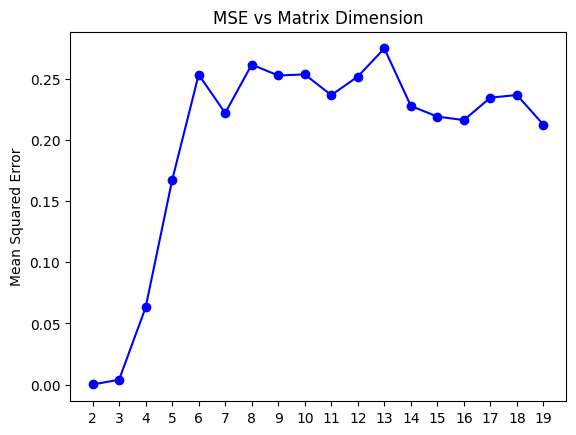

In [10]:
matrix_sizes, data, train_fraction = set_params()

for size in matrix_sizes:
    for _ in range(1000):  # Generate 1000 samples per size
        matrix = generate_hermitian_matrix(size)
        eigenvalues = get_sorted_eigenvalues(matrix)
        data.append((matrix, eigenvalues))

# Shuffle and split data
np.random.shuffle(data)
train_data = data[:int(train_fraction * len(data))]
test_data = data[int(train_fraction * len(data)):]

# Train and evaluate the model for each matrix size
mse_errors = []

for size in matrix_sizes:
    input_size = size * size
    output_size = size
    
    model = MLP(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_data_size = [d for d in train_data if d[0].shape[0] == size]
    test_data_size = [d for d in test_data if d[0].shape[0] == size]
    
    train_loader = prepare_data_loader(train_data_size, batch_size=64)
    test_loader = prepare_data_loader(test_data_size, batch_size=64)
    
    model = train_model(model, train_loader, criterion, optimizer, epochs=500)
    mse = evaluate_model(model, test_loader, criterion)
    
    mse_errors.append(mse)
    print(f"Matrix size {size}x{size}: MSE = {mse}")

# Plotting MSE as a function of matrix size
plt.plot(matrix_sizes, mse_errors, marker='o', color='blue')
plt.xticks(matrix_sizes) # force yticks to be integers
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Matrix Dimension')
plt.show()